In [6]:
import PyPDF2
import re
import pandas as pd
import numpy as np
from pdfminer.high_level import extract_text
from pdfminer.layout import LAParams
import random
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from unidecode import unidecode
from itertools import compress
from fuzzywuzzy import process, fuzz

# Parser Performance

This function calculates a series of metrics for each output from the parsing of a single PDF. These metrics help to establish the performance  of each parser and compare among them. 

Different metrics have been selected based on the available information and the associated usefulness. 
The length of the title and poster strings are useful to determine the number of notable outliers that would indicate misclassified items, such as remarkably short titles or extremely lengthy authors. Thus we include both a histogram and the 90% interval of values. Using the name database shown next we can compare the histogram of names length to the histogram of the authors names.  

Moreover, for the poster topics, we include the frequency count of each poster topic detected. 

Lastly, we examine the proportion of non-missing values to the number of pages sampled. Under the assumption that, in the current files, each page contains but one poster this metric should reflect the number of poster information "correctly" extracted.
The metrics include:

* Histogram of poster title length (in characters)
* Histogram of author name lenght calculated (number of words separated by whitespace)
* 95-5 percentiles and count of poster title and author name length
* Values count for the poster topics

In [107]:
def parser_performance(dataset, no_pages = None):
    title_len = dataset['titulo'].dropna().str.len().values
    authors = dataset['autor'].dropna()
    authors = authors.apply(lambda x: unidecode(x))
    authors = authors.apply(lambda x: re.compile(r'[a-zA-Z\s]*').search(x).group())
    authors_len = authors.str.split(' ').apply(len).values
    print('\n','Authors names length','\n')
    plt.hist(authors_len)
    plt.show()
    print('\n','Poster title length','\n')
    plt.hist(title_len)
    plt.show()
    author_95 = np.percentile(authors_len, [5,95])
    title_95 = np.percentile(title_len, [5,95])
    print('-'*50)
    print('Authors')
    print('5-95 percentiles:','\n',
          '5th: {percentil5}'.format(percentil5 = author_95[0]),' - ',
          '95th: {percentil95}'.format(percentil95 = author_95[1]),'\n',
         '5th count: {cuenta5}'.format(cuenta5 = np.sum(authors_len < author_95[0])),' - ',
         '95th count: {cuenta95}'.format(cuenta95 = np.sum(authors_len > author_95[1])),
        '\n',
         '-'*50,
        '\n',
          'Titles',
        '\n',
          '5-95 percentiles:',
        '\n',
          '5th: {percentil5}'.format(percentil5 = title_95[0]),' - ',
          '95th: {percentil95}'.format(percentil95 = title_95[1]),'\n',
         '5th count: {cuenta5}'.format(cuenta5 = np.sum(title_len < title_95[0])),' - ',
         '95th count: {cuenta95}'.format(cuenta95 = np.sum(title_len > title_95[1])),
        '\n',
         '-'*50,
        '\n',
            dataset['tema'].value_counts()
         )


 Authors names length 



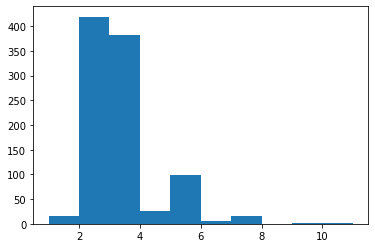


 Poster title length 



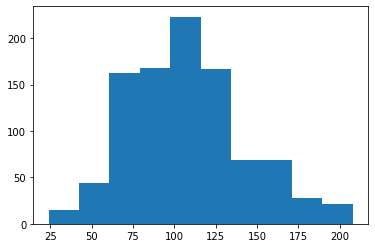

--------------------------------------------------
Authors
5-95 percentiles: 
 5th: 2.0  -  95th: 5.0 
 5th count: 16  -  95th count: 24 
 -------------------------------------------------- 
 Titles 
 5-95 percentiles: 
 5th: 55.0  -  95th: 175.5 
 5th count: 48  -  95th count: 49 
 -------------------------------------------------- 
 Cellular and Molecular Neurobiology      379
Cognition, Behavior, and Memory          252
Neurochemistry and Neuropharmacology     122
Neural Circuit Physiology                 87
Chronobiology                             71
Motor Systems                             31
Computational Neuroscience                23
Cellular and Molecular neurobiology        1
Name: tema, dtype: int64


In [108]:
#Example of the function use and output
parser_performance(pd.read_csv('../SAN_csv/SAN_2015.csv'))

# Name Database

Load the dataset containing all the names of the science and technology staff according to data from the [SICTYAR](https://datos.gob.ar/dataset/mincyt-personal-ciencia-tecnologia). 

In [13]:
personas = pd.read_csv('personas.csv', sep = ';', low_memory = False,
                      encoding='UTF-8')
personas_na = personas[personas['nombre'].notna()]

Step by step:

* Clean the name format using unidecode
* Transform all names to lowercase
* Split the string by each word and count the frequency of each one

In [14]:
nombres_personas = personas_na['nombre'].map(unidecode).str.lower().str.split(expand=True).stack().value_counts()

Filter the results to leave only words with a frequency higher than 150

In [15]:
nombres_personas = nombres_personas[nombres_personas >= 150]

This list can be used as a target keyword container to detect the presence of author names in a certain parsed element. Although it is only used in the 2012 function we add the whole process inside the wrapper function before the iteration over each dictionary key.

# Parsing

Next, there will be a code breakdown for each pdf file parsing function. 

## SAN 2019

This function takes one argument, the parsed pdf string.

The pdf file for this year contains the poster topic as the first element when the string is divided by a newline. 

The title is found by using a regex approach where each string of the list that results from splitting the pdf page by two consecutive newlines is evaluated to a boolean if it doesn't return a Match object for the title regex. 

Finally the authors are given by the second element of the list that results from splitting the pdf page by two non-consecutive newlines. 

It returns a pandas data frame object.

In [79]:
def san_2019_parser(poster_string):
    tema = poster_string.split('\n')[0]
    titulo = compress(
            poster_string.split('\n\n'), 
            [titulo_regex.search(elements) != None for elements in poster_string.split('\n\n')]
    )
    autores = poster_string.split('\n \n')[2]
    return pd.DataFrame(
                {'autor': autores.split(','),
                'tema': tema,
                'poster': titulo}
                )

## SAN 2018

This function takes one argument, the parsed pdf string.

The pdf file for this year exhibits the same structure as the file from 2019, therefore it follows the same parsing procedure with the exception of the authors which are extracted via the index of the next element after the title when splitting the pdf page by two consecutive newlines and then selecting the first element of the resulting string after splitting it by two non-consecutive newlines.

It returns a pandas data frame object.

In [ ]:
def san_2018_parser(poster_string):
    tema = poster_string.split('\n\n')[0]
    titulo = compress(
            poster_string.split('\n\n'), 
            [titulo_regex.search(elements) != None for elements in poster_string.split('\n\n')]
    )
    autores = poster_string.split('\n\n')[[titulo_regex.search(elements) != None for elements in poster_string.split('\n\n')]].split('\n \n')[0]
    return pd.DataFrame(
                {'autor': autores.split(','),
                'tema': tema,
                'poster': titulo}
                )

## SAN 2017

The parsing function for this year's pdf takes two arguments. Both arguments are strings obtained from the same pdf page with different parsing methods, pdfminer and PyPDF2, respectively.

The poster topic is obtained by indexing the second element after splitting the string by two whitespaces. The poster title is the following element to the topic and the authors are obtained by indexing the third element after splitting the pdf string by two non-consecutive newlines.

It returns a pandas data frame object with the same structure as the template data frame.

In [44]:
def san_2017_parser(poster_str, poster_str2):
    #Lista con los datos del poster 
    poster_spliteado = poster_str.split('  ')
    #Tema del poster
    tema = poster_spliteado[1].strip()
    #Titulo del poster
    titulo = poster_spliteado[2]
    #Lista con los autores del poster
    autores = poster_str2.split('\n \n')[2].split(',')
    #
    return pd.DataFrame(
                    {'autor': autores,
                    'poster': titulo,
                    'tema': tema}
                    )

Itero por cada pagina dentro del rango definido anteriormente y para cada una extraigo los datos usando la libreria pdfminer y PyPDF2 para entregarle las strings como argumento a la funcion

## SAN 2016

For this Annual Meeting, under the auspices of FALAN Buenos Aires Meeting, several events were held:
* The¨XXXIX Reunião Anual da la Sociedade Brasileira de Neurociências e Comportamento¨
* The ¨XII Reunión Anual de la Sociedad Chilena de Neurociencias¨
* The ¨XV Jornadas de la Sociedad de Neurociencias del Uruguay¨
* The ¨XXXI Congreso Anual de la Sociedad Argentina de Investigación en Neurociencias"

This means that there is a huge mixture of authors (non-members of the SAN) in the poster session as well as an increase number of posters, in addittion to a problematic layout in the PDF file.

For these reasons the Annual Meeting of 2016 was excluded from the parsing process.

## SAN 2015

This function takes one argument, a parsed pdf string. 

The poster topic is extracted by indexing the second element from the list created by splitting the parsed string by two non-consecutive newlines. The poster title is the following element.

The poster authors and afiliations are the fourth element by indexing the list created by splitting the parsed string by two non-consecutive newlines. The result is then splited by a newline after which two new variables are assigned corresponding to the first and second element with error handling for the second element that prompts a return statement thus halting the code at that point.  
In addition, a conditional statement evaluates if the length of the string from the first element of the authors list is higher than 85 which would indicate the presence of a great number of authors and increases the likelihood of the next element also containing author names.  
Therefore, when the conditional statement evaluates to True, the second element is examined for the presence of 3 keywords to determine if it corresponds to more authors or to affiliations. If some of the keywords returns a match then only the first element is used and is transformed in the same way as if the length of the first element was less than 85. 
When the conditional statement evaluates to False, the second element and the first element are combined and transformed to create the final authors list.

It returns a pandas data frame object.

In [7]:
def san_2015_parser(poster_string):
    tema = poster_string.split('\n \n')[1]
    titulo = poster_string.split('\n \n')[2]
    titulo = ''.join(titulo.splitlines())
    autores = poster_string.split('\n \n')[3]
    elementos = autores.split('\n')
    primer_elemento = elementos[0]
    try:
        segundo_elemento = elementos[1]
    except:
        print(f'Error en pagina {i + 1}')
        return()
    if len(primer_elemento) > 85:
        if 'Laboratorio' in segundo_elemento or 'Instituto' in segundo_elemento or 'CONICET' in segundo_elemento:
            autores = primer_elemento.split(',')
        else:            
            autores = ''.join(autores.split('\n')[0:2]).split(',')
    else:
        autores = primer_elemento.split(',')
    return pd.DataFrame(
                        {'autor': [autor.strip() for autor in autores],
                        'poster': titulo,
                        'tema': tema}
                        )

## SAN 2014

No element in the pdf structure allow us to distinguish between the elements containing the title, authors or affiliations. 

As a consequence, we first iterate over all the posters containing pages from the pdf and tokenize the strings of the elements that are most likely to hold affiliation data. Afterward, we calculate the frequency of each term and manually select relevant non-redundant words from the most frequent ones to create an affiliations keywords list.  
Since this process needs to be performed only once and the keyword selection is done manually, to avoid including non-related keywords, the code to generate the keywords list is not included in the parsing function. 

In [ ]:
#Creo una serie de pandas con los tokens identificados del tercer y cuarto elemento de cada pagina
res = pd.Series()
tk = WordPunctTokenizer()
for i in range(43,192):
    tmp_page = extract_text('SAN_2014.pdf', page_numbers=[i]).split('\n')
    word_list = tk.tokenize(tmp_page[3] + tmp_page[4]) 
    res = res.append(pd.Series(word_list), True)
#Ordeno los elementos segun frecuencia
res.value_counts()[:30]

The most relevant keywords to identify affiliations are:
* CONICET
* Instituto
* Laboratorio
* Facultad
* Argentina
* Universidad
* Departamento

In [ ]:
filiaciones_keywords_2014 = ['CONICET', 'Instituto', 'Laboratorio', 'Facultad', 'Argentina', 'Universidad', 'Departamento']

The function takes one argument

_poster_string_ = expects a string resulting from the parsing of a page from the pdf file  


The poster topic appears only once, in the first poster of that topic. Thus, the poster topic must remain the same for all the posters following the first until another poster topic appears. Therefore we create a global variable inside the function for the poster topic but assing it a different name reflecting the unique nature of this variable for this pdf file and, primarily, to avoid collisions with the (same name) variable in the local environment of the other functions.  
If the first element is considered a poster topic the global poster variable is assigned to that element, otherwise the first element is considered the poster title. Therefore we add the global poster topic variable to the wrapper function.

To distinguish between the authors and the title we employ a regex approach by taking advantage of the author's structure. We use two regex patterns, one for the authors and one for the title. The regex title is the same we use in the 2018 or 2019 files so we only need to generate the regex pattern for the authors and since this regex is only used in this parser we include it as a local variable inside the function.  
Therefore, if the regex returns a list with a length lower than 2 we may conclude that it is not the element that contains the authors.  
However this method cannot accurately detect posters with only one author although, ancedotally, it is a rare ocurrence within this file. 


In order to distinguish between authors and affiliations we employ a keyword approach with fuzzy string matching. As a consequence if the element under examination contains a high score it will be considered as an affiliations element.

Lastly, to distinguish pages were the first element is the posters topic insted of the title we again employ a regex approach to examine the existence of the letter P followed by some digit and the characters ".-" that preced every poster title. 

In [ ]:
def san_2014_parser(poster_string, tema_2014 = 'Cellular and Molecular Neurobiology'):
    autores_regex = re.compile(r'(\S*\s\S*),')
    res_df = pd.DataFrame({'autor': [], 'poster': [], 'tema':[]})
    #Separo la string segun newlines
    string_separada = poster_string.split('\n')
    #Chequeo si el primer elemento es el tema del poster o el titulo
    if titulo_regex.search(string_separada[0]) == None:
        #Si es True considero que el primer elemento es el tema del poster y no el titulo
        global tema_2014
        tema_2014 = string_separada[0]
        titulo = string_separada[2]
        indice = 2
    else:
        #Si es False considero que el primer elemento es el titulo del poster
        titulo = string_separada[0]
        indice = 0
    #Chequeo si el proximo elemento es parte del titulo segun la longitud del resultado del regex
    if len(autores_regex.findall(string_separada[indice + 1])) < 2:
        #Si es True considero que es parte del titulo por lo que se lo agrego a la variable
        titulo = titulo + ' ' + string_separada[indice + 1]
        autores = string_separada[indice + 2]
        indice = indice + 2
    else:
        #Si es False considero que no es parte del titulo sino que son los autores
        autores = string_separada[indice + 1]
        indice = indice + 1
    #Chequeo si el proximo elemento es parte de los autores o de las filiaciones
    if any(afil_key in string_separada[indice + 1] for afil_key in filiaciones_keywords_2014) or process.extractOne(query = string_separada[indice + 2], choices = filiaciones_keywords_2014, scorer = fuzz.partial_ratio)[1] > 85:
        #Si es True entonces el elemento son las filiaciones y no es de interes
        pass
    else:
        #Si es False entonces el elemento aun contiene autores y tengo que agregarlo a la lista anterior
        autores = autores + string_separada[indice + 2]
    #Itero por cada autor usando las comas como separador
    for aut in autores.split(','):
        tmp_df = pd.DataFrame(
            {'autor': [aut], 'poster': [titulo], 'tema': [tema_2014]}
        )
        res_df = res_df.append(tmp_df)
    return(res_df)

## SAN 2013

As we've done in the SAN 2014 parsing function, we generate the affiliations keywords list after tokenizing the strings from the third and fourth element of all the pages that contain poster information. Again, we manually select relevant keywords to construct the list, and we don't include the code in the parsing function following the same reasons as before. Although in this case, we search the 50 most frequent tokens instead of the 30 most frequent ones.

In [ ]:
#Creo una serie de pandas con los tokens identificados del tercer y cuarto elemento de cada pagina
res = pd.Series()
for i in tqdm(range(113,341)):
    tmp_page = extract_text('SAN_2013.pdf', page_numbers=[i]).split('\n \n')[2].split('\n')
    try:
        word_list = tk.tokenize(tmp_page[2] + tmp_page[3] + tmp_page[4] + tmp_page[5]) 
        res = res.append(pd.Series(word_list), True)
    except:
        continue
res.value_counts()[:50]

In [ ]:
filiaciones_keywords_2013 = {'CONICET', 'Facultad', 'Instituto', 'Universidad', 'University', 'Laboratorio', 'Laboratory', 'Argentina', 'UBA', 'Departamento'}

The function takes one argument, a string resulting from the parsing of a page from the pdf file

The poster theme is given by the first element of the parsed PDF file, splited by a newline. 

The title may be given by different elements with different splitting methods. To recognize a parsing falilure we examine the element's length and if it exceeds 1000 characters we asume the element contains more than the title. We first try the second element of the parsed PDF file, splited by two non-consecutive newlines. Upon failure for the above criteria we try the second element splitted by two consecutive newlines and, ultimately, we use the poster session element to locate the title. 

There is no constant division between the authors and the title, sometimes it is given by one newline, two consecutive newlines or two non-consecutive newlines. Thus we use the title to split the parsed PDF file, thus making sure that the second element contains the authors along with the afiliations. To separate the authors from the afiliations and the rest of the parsed file we implement a procedure similar to the one in the SAN 2014 file. 

In [ ]:
def san_2013_parser(poster_string):
    #Topic
    tema = poster_string.split('\n')[0]
    #Title
    titulo = poster_string.split('\n \n')[1]
    #If the title has a lenght greater than 1000 it means the variable contains more elements than just the title
    if len(titulo) > 1000:
        #It may be the spliting parameter so we try a different newline combination
        titulo = poster_string.split('\n\n')[1]
        #If this newline also fails (given by a huge length) it may separation between the title and the poster/session
        if len(titulo) > 1000:
            #To solve it, we split with the poster/session element and select the last element
            #The poster/session element is the second element, splited by newlines, in the first element splited by two consecutive newlines
            titulo = poster_string.split('\n\n')[0].split(poster_string.split('\n\n')[0].split('\n')[1])[-1]
    #Empty string to held the authors names
    autores = ''
    #Divide the string by the title    
    potenciales_autores = poster_string.split(titulo)[1].split('\n') #Element containing the authors, afiliations and poster text
    #Index to start iterating in the first element of potenciales_autores
    a_i = 0
    #Continue until any word in the i element of potenciales_autores is in the list of filiaciones_keywords
    #Any element beyond the one who fullfils these requirements doesn't contain any authors and is not of interest
    while not any([p in filiaciones_keywords_2013 for p in potenciales_autores[a_i].split(' ')]):
        print(a_i)
        #Break the loop if it reaches a long underscore line which indicates the beginning of the poster text
        if "_" in potenciales_autores[a_i]:
            #If the loop reaches this conditional it means it failed to detect afiliations, thus display a warning
            print('ERROR! No se detectaron filiaciones')
            break
        #Add authors to the autores list variable only if the i element has a length greater than 2
        #This is done to avoid elements like ' ' to be added
        elif len(potenciales_autores[a_i].strip()) > 2:
            autores = autores + potenciales_autores[a_i]
        else:
        #Skip the element if above conditions are not met
            pass
        #Move on to the next element
        a_i += 1 
    #Split authors by commas to get one author per element in a list
    autores = autores.split(',')
    #Dictionary containing topic, title and authors from the poster
    return pd.DataFrame(
            {'tema': [tema], 
             'poster': [titulo], 
             'autor': [autores]}
    ) 

# SAN 2012

Genero el dataset que va a albergar los resultados

In [ ]:
san_2012_df = pd.DataFrame(columns= ['tema', 'autor', 'titulo'])

Again we follow the same procedure as in the SAN 2014 and 2013 by examining tokenized strings from elements eigth to eleven to come up by the affiliations keywords list.

In [ ]:
res = pd.Series()
for i in range(42,249):
    tmp_page = extract_text('SAN_2012.pdf', page_numbers=[i]).split('\n')
    try:
        word_list = tk.tokenize(tmp_page[7] + tmp_page[8] + tmp_page[9] + tmp_page[10]) 
        res = res.append(pd.Series(word_list), True)
    except:
        continue
res.value_counts()[:50]

In [ ]:
filiaciones_keywords_2012 = ['conicet', 'uba', 'facultad', 'universidad', 'instituto', 'buenos aires', 'laboratorio', 'argentina', 'departamento', 'university', 'department']

The function takes one argument, a string resulting from the parsing of a page from the pdf file.

Poster theme is always the third element of the newline-separated document.

To find the title we first iterate over each element of the newline-separated document until we find a reference to the poster number and session, the index of the following element is the beginning of the title. From there we move to the next element, adding it to the title string until a stopping criterion is met. The criterion is given by both the presence of a comma and the presence of at least one name from the MinCyT database. 

The index of the element which fulfills the stopping criterion is the beginning of the authors names. We move to the next element, adding it to the authors string until at least one afiliation keywords is found. 

If an at sign is detected when iterating over elements presumably containing authors names, and error is displayed and the authors names string is replaced by an error string.

The function returns a pandas dataframe containing the theme, title and one author per row. 

In [ ]:
def san_2012_parser(poster_string):
    poster_split = poster_string.split('\n')
    tema = poster_split[2] #Theme
    #Title
    t_i = 0
    try:
        while 'poster number' not in poster_split[t_i].lower(): #Search elements by index until reference words are found
            t_i += 1 #Go to the next element
    except:
        return
    #t_i contains the poster and session reference
    #The title starts at t_i + 1
    t_i += 1
    #Empty title string
    titulo = ''
    #Any element lacking a comma and a name is considered part of the title
    while ',' not in poster_split[t_i] and not any([x in unidecode(poster_split[t_i].lower()) for x in nombres_personas.keys()]): 
        titulo = titulo + poster_split[t_i] #Add the element to the title
        t_i += 1 #Go to the next element
    #The authors start at the t_i + 1 element
    a_i = t_i + 1
    #Empty authors string 
    autores = ''
    #If there is no match for the afilitations keywords then we assume the element contains authors names
    while not any([p in poster_split[a_i].lower() for p in filiaciones_keywords_2012]):
        #Add the element to the authors string
        autores = autores + poster_split[a_i]
        a_i += 1 #Move to the next element
        #Check that the loop doesn't reach an element containing an 'at sign'
        if '@' in poster_split[a_i]:
            #If True
            #Display an error message with the number of the page
            print(f'ERROR! in {t_i}, page number {i}')
            #Add the ERROR string to the authors strings to facilitate detection of failed pages
            autores = autores + 'ERROR'
            #Break the loop to avoid looping over other non-useful elements
            break
    return pd.DataFrame({'tema': tema, 'autor': autores.split(','), 'poster': titulo})

We already now that, according to the function output, page 171 and 54 failed to identify authors. If we wish we could visually examine the output of _"extract_text"_. 

In [ ]:
extract_text('SAN_2012.pdf', page_numbers=[54]).split('\n')

In [ ]:
extract_text('SAN_2012.pdf', page_numbers=[171]).split('\n')

As expected, there are only two rows containing the word ERROR in the _"autor"_ column. For the page 54 poster, only the last author and the afiliations were detected and added as authors. Moreover the title was no captured. 

For the poster in page 171, the title was accurately captured but it failed to capture the authors name. 

In [ ]:
san_2012_df[san_2012_df['autor'].apply(lambda x: 'ERROR' in x)]

First we eliminate these rows from the dataframe.

In [ ]:
san_2012_df = san_2012_df.drop([36,380])

Then we add them manually

In [ ]:
san_2012_df = pd.concat(
[san_2012_df, pd.DataFrame({'tema': 'Cellular and Molecular Neurobiology', 'autor': ['Victor Danelon', 
                                                                        'Andrea B. Cragnolini', 
                                                                        'Daniel H. Masco'],
              'titulo': "An in vitro model of SE induces neuronal death and changes in the levels of TrkB, pTrkB and p75ntr receptors in a mixed culture of neurons and astrocytes"})]
)
san_2012_df = pd.concat(
[san_2012_df, pd.DataFrame({'tema': ['Computational Neuroscience'], 'autor': ['Juan Pablo Oliver'],
                           'titulo': ['Active mapping of brain']})]
)

Finally we reset the index and drop the redundant index columns

In [ ]:
san_2012_df = san_2012_df.reset_index().drop(['level_0','index'], axis = 1)

This whole process is done manually only once at the end of the document parsing for this pdf file in particular. Thus we encapsulate it within its own function to be applied at the end of the iteration process for the 2012 file only. 

In [1]:
def san_2012_fix(df_2012):
    df_2012 = df_2012.drop([36,380])
    df_2012 = pd.concat(
        [df_2012, pd.DataFrame({'tema': 'Cellular and Molecular Neurobiology', 'autor': ['Victor Danelon', 
                                                                                'Andrea B. Cragnolini', 
                                                                                'Daniel H. Masco'],
                      'titulo': "An in vitro model of SE induces neuronal death and changes in the levels of TrkB, pTrkB and p75ntr receptors in a mixed culture of neurons and astrocytes"})]
        )
    df_2012 = pd.concat(
        [df_2012, pd.DataFrame({'tema': ['Computational Neuroscience'], 'autor': ['Juan Pablo Oliver'],
                                   'titulo': ['Active mapping of brain']})]
        )
    df_2012 = df_2012.reset_index().drop(['level_0','index'], axis = 1)
    return df_2012

***

## Wrapper

For the SAN posters of the years 2019 to 2015 we generate an empty pandas data frame to hold the results from the parsing process and we create a dictionary containing:

* The range of pages that hold posters
* The parsing function for the given year 
* The pdf file for the given year

The range of pages for each file is determined by manually inspecting the pdf file. 

Generate a dummy pandas dataframe from the data frame template.

Next, iterate over each SAN year and then iterate over the range of poster containing pages from that year, select appropiate parsing function and file path. 

In [ ]:
df_template = pd.DataFrame(columns = ['autor', 'tema', 'poster'])

san_posters = {
    'san_2019': [range(2,257), san_2019_parser, '../SAN_Books/SAN_2019.pdf'],
    'san_2018': [range(76,362), san_2018_parser, '../SAN_Books/SAN_2018.pdf'],
    'san_2017': [range(48,212), san_2017_parser, '../SAN_Books/SAN_2017.pdf'],
    'san_2015': [range(94,100), san_2015_parser, '../SAN_Books/SAN_2015.pdf'],
    'san_2014': [range(45,192), san_2014_parser, '../SAN_Books/SAN_2014.pdf'],
    'san_2013': [range(113,341), san_2013_parser, '../SAN_Books/SAN_2013.pdf'],
    'san_2012': [range(42,249), san_2012_parser, '../SAN_Books/SAN_2012.pdf']
}

titulo_regex = re.compile(r'P(\d)+.-')

Most SAN posters files follow the same parsing logic by employing the _extract_text()_ function from the pdfminer library. However,the 2017 file requires a different parsing logic by combining two different methods from two different libraries thus requiring a conditional statement to allow flow control under the dictionary keys iteration. Likewise the 2012 file requires certain fixes after parsing. 

At the end of each iteration, the data frame generated from the pdf file is stored in a .csv file with a name matching the name of the dictionary key.

In [ ]:
def san_parser_wrapper():
    tema_2014 = 'Cellular and Molecular Neurobiology'
    personas = pd.read_csv('personas.csv', sep = ';', low_memory = False,
                      encoding='UTF-8')
    personas_na = personas[personas['nombre'].notna()]
    nombres_personas = personas_na['nombre'].map(unidecode).str.lower().str.split(expand=True).stack().value_counts()
    nombres_personas = nombres_personas[nombres_personas >= 150]
    for i in san_posters.keys():
        temporary_df = df_template.copy()
        if i == 'san_2017':
            #Open and read the corresponding pdf file
            san_2017_pdf = open(san_posters[i][2], 'rb')
            #Construct the reader object with the pdf file previously opened
            san_2017_reader = PyPDF2.PdfFileReader(san_2017_pdf)
            #Iterate as always over the range of pages
            for p in san_posters[i][0]:
                #First parsing method
                parseo_1 = san_2017_reader.getPage(p).extractText()
                #Second parsing method.
                parseo_2 = extract_text(san_posters[i][2], page_numbers=[p])
                temporary_df = pd.concat(
                [
                    temporary_df,
                    san_posters[i][1](parseo_1, parseo_2)
                ]
                )
        else:
            for p in san_posters[i][0]:
                temporary_df = pd.concat(
                    [
                    temporary_df, san_posters[i][1](extract_text(san_posters[i][2], page_numbers = [p]))
                    ]
                )
        temporary_df = temporary_df.reset_index()
        if i == 'san_2012':
            temporary_df = san_2012_fix(temporary_df)
        temporary_df.to_csv('../SAN_csv/' + i + '.csv')